<a href="https://colab.research.google.com/github/sanha-hwang/ocular_disease/blob/main/cataract_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 안구질환 인식 - 캐글 필사



캐글에서 안구질환 인식 데이터를 받아 안구질환을 진단하는 모델을 만들어보자<br>    
5000명의 환자의 안저 사진 데이터가 있고 라벨로는 일반 : N, 당뇨병 : D, 녹내장 : G, 백내장 : C, 연령 관련 황반변성 : A, 고혈압 : H, 병적 근시 : M, 기타 질병 / 이상 : O

  - Normal (N),
  - Diabetes (D),
  - Glaucoma (G),
  - Cataract (C),
  - Age related Macular Degeneration (A),
  - Hypertension (H),
  - Pathological Myopia (M),
  - Other diseases/abnormalities (O)

- 이미지 분류 잘하는 모델 만들기 목표 80프로 이상

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.8.0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12622508783315963189
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16739146462045684250
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow
from tensorflow import keras

base_dir = "/content/drive/MyDrive/"
dataset_dir = os.path.join(base_dir,'dataset')
dataset_path = os.path.join(dataset_dir,'full_df.csv')

image_dir = os.path.join(dataset_dir, 'preprocessed_images')

print(dataset_path)
print(image_dir)

/content/drive/MyDrive/dataset/full_df.csv
/content/drive/MyDrive/dataset/preprocessed_images


In [ ]:
data = pd.read_csv(dataset_path)

In [ ]:
data.tail()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg
6391,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4784_left.jpg


In [ ]:
def has_cataract(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [ ]:
data['left_cataract'] = data['Left-Diagnostic Keywords'].apply(lambda x : has_cataract(x))
data['right_cataract'] = data['Right-Diagnostic Keywords'].apply(lambda x : has_cataract(x))


In [ ]:
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,0


In [ ]:
## label도 C, 진단 키워드도 cataract를 포함하고 있는 경우를 선택

left_cataract = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = data.loc[(data.C ==1) & (data.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = data.loc[(data.C ==0) & (data["Left-Diagnostic Keywords"] \
                                         == 'normal fundus')]["Left-Fundus"].sample(250, random_state=42).values
left_normal[:15]

array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
       '4176_left.jpg', '2711_left.jpg', '4614_left.jpg', '3174_left.jpg',
       '2862_left.jpg', '2424_left.jpg', '3193_left.jpg', '3306_left.jpg',
       '2961_left.jpg', '2425_left.jpg', '2858_left.jpg'], dtype=object)

In [ ]:
right_normal = data.loc[(data.C ==0) & (data["Right-Diagnostic Keywords"] \
                                         == 'normal fundus')]["Right-Fundus"].sample(250, random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate([left_cataract, right_cataract], axis = 0)
normal = np.concatenate([left_normal, right_normal], axis = 0)

In [ ]:
len(cataract), len(normal)

(594, 500)

In [ ]:
test = cv2.imread(os.path.join(image_dir,normal[0]))

In [ ]:
test.shape

(512, 512, 3)

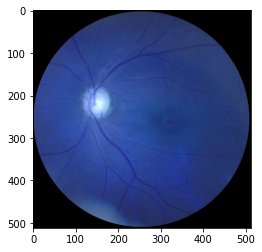

In [ ]:
plt.imshow(test)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import random

image_size = 224

dataset = []

def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_dir,img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            
        except:
            
            continue
        
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(cataract, 1)

100%|██████████| 594/594 [01:44<00:00,  5.70it/s] 


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal, 0)

100%|██████████| 500/500 [02:33<00:00,  3.27it/s]


In [ ]:
len(dataset)

1088

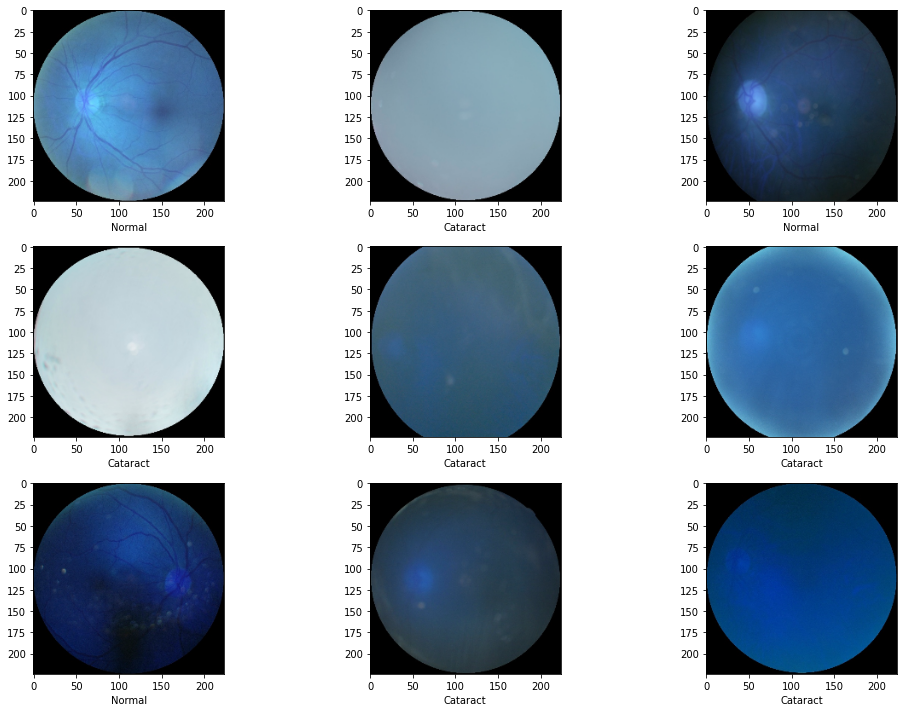

In [ ]:
plt.figure(figsize=(15,10))
for i in range(9):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)


In [ ]:
from tensorflow.keras.applications import EfficientNetB2

efficientnet = EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(image_size,image_size,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax")


31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential()
model.add(efficientnet)
model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalMaxPooling2D())
model.add(tf.keras.layers.Activation('sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1)           1409      
                                                                 
 dropout (Dropout)           (None, 7, 7, 1)           0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1)          4         
 ormalization)                                                   
                                                                 
 global_max_pooling2d (Globa  (None, 1)                0         
 lMaxPooling2D)                                                  
                                                                 
 activation (Activation)     (None, 1)                 0

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("effnetv2.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 33s 420ms/step - loss: 0.4616 - accuracy: 0.7552 - val_loss: 9.9745 - val_accuracy: 0.5000
Epoch 2/15
28/28 [==============================] - 9s 330ms/step - loss: 0.3310 - accuracy: 0.9241 - val_loss: 1.9781 - val_accuracy: 0.5000
Epoch 3/15
28/28 [==============================] - 9s 330ms/step - loss: 0.3289 - accuracy: 0.9299 - val_loss: 0.8993 - val_accuracy: 0.7110
Epoch 4/15
28/28 [==============================] - 9s 331ms/step - loss: 0.2739 - accuracy: 0.9586 - val_loss: 1.1892 - val_accuracy: 0.6468
Epoch 5/15
28/28 [==============================] - 9s 326ms/step - loss: 0.2441 - accuracy: 0.9598 - val_loss: 0.8208 - val_accuracy: 0.7523
Epoch 6/15
28/28 [==============================] - 9s 329ms/step - loss: 0.2295 - accuracy: 0.9609 - val_loss: 0.3337 - val_accuracy: 0.9404
Epoch 7/15
28/28 [==============================] - 9s 329ms/step - loss: 0.2198 - accuracy: 0.9644 - val_loss: 0.3431 - val_accuracy: 0.9220
Epoch

In [ ]:
loss,accuracy = model.evaluate(x_test, y_test)
print("loss:",loss)
print("Accuracy:",accuracy)


7/7 [==============================] - 0s 58ms/step - loss: 0.2013 - accuracy: 0.9679
loss: 0.2012682855129242
Accuracy: 0.9678899049758911


In [ ]:
y_test

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predict_x = model.predict(x_test)
classes_x = np.argmax(predict_x > 0.5).astype("int32")


In [ ]:
classes_x

2

In [ ]:
predicted

array([79])

In [ ]:
accuracy_score(y_test,predicted)

0.5